<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241206_local_quick_dataviewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import json
import pandas as pd
import requests

from IPython.display import display, HTML
import markdown
from pygments import highlight
from pygments.lexers import get_lexer_by_name
from pygments.formatters import HtmlFormatter
from IPython.core.display import display, HTML
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 1000})'''))

/var/folders/fz/bwkd624d779gp9w9grfp_sdr0000gn/T/ipykernel_71458/3730989698.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


<IPython.core.display.Javascript object>

In [ ]:
#@title just easy show conversation for debugging  (code by Grok)
import inspect

# sys.path.append(os.path.expanduser('~/xai/train/'))

# import tkinter as tk
from IPython.display import HTML, display


def display_conversation(conversation, conv_loss_mask=None, ratings=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles,
    and show thumbs up or down based on ratings.

    Parameters:
    - conversation (list of dict or str): List where each element can be a dictionary with 'role' and 'content' or just a string.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    - ratings (list of str): List of strings where 'LIKE' means thumbs up, 'DISLIKE' means thumbs down.
    """
    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""
    roles_default = ["user", "assistant"]

    for i, entry in enumerate(conversation):
        if isinstance(entry, str):
            role = roles_default[i % 2]
            content = entry
        else:
            role = entry["role"]
            content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"
        rating_display = ""

        # Add rating icon if ratings are provided
        if ratings and i < len(ratings):
            rating = ratings[i]
            if rating == 'LIKE':
                rating_display = "&#x1F44D;"  # Thumbs up emoji
            elif rating == 'DISLIKE':
                rating_display = "&#x1F44E;"  # Thumbs down emoji

        # Highlight if conv_loss_mask is True for this message
        highlight_style = "font-weight: bold; text-decoration: underline;" if conv_loss_mask and conv_loss_mask[i] else "font-weight: normal;"

        # Append each entry to HTML string with styling and rating icon
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong> {rating_display}<br>
            <span style='{highlight_style}'>{content}</span>
        </div>
        """

    display(HTML(html_output))


In [235]:
#@title just easy show rubrics + comparision  (code by Grok)

# Function to apply syntax highlighting
def syntax_highlight(code, language='python'):
    lexer = get_lexer_by_name(language, stripall=True)
    formatter = HtmlFormatter(style='monokai', noclasses=True)
    return highlight(code, lexer, formatter)

# Function to convert Markdown to HTML with code highlighting
def markdown_to_html(markdown_text):
    # Use markdown.markdown for older versions of markdown
    return markdown.markdown(markdown_text, extensions=['fenced_code', 'codehilite'])


def display_rubrics_ratings(data):
  # print(data['point_wise_scores'])
  # print(data['ranked_model_list'])
  prompt = data['prompt']
  rubrics = data['rubrics']
  html_content = ""
  rubrics_count = len(rubrics)//2

  criteria_mapping = {}
  criteria_rating = {}
  for i in range(len(rubrics)):
      criteria = rubrics[i]['criteria']
      criteria_mapping[criteria] = criteria_mapping.get(criteria, {}) | {rubrics[i]['metadata']['model']: i}
      criteria_rating[criteria] = criteria_rating.get(criteria, {}) | {rubrics[i]['metadata']['model']: int("yes" == rubrics[i]['label'])}
  model_order = []
  for criteria in criteria_mapping:
    grok = 1 - int('grok' in list(criteria_mapping[criteria])[0])
    criteria_mapping[criteria] = [v for k, v in criteria_mapping[criteria].items()]
    criteria_mapping[criteria] = criteria_mapping[criteria][::-1] if grok else criteria_mapping[criteria]
    model_order = criteria_mapping[criteria]
    criteria_rating[criteria] = [v for k, v in criteria_rating[criteria].items()]
    criteria_rating[criteria] = criteria_rating[criteria][::-1] if grok else criteria_rating[criteria]

  grok = int('grok' in data['ranked_model_list'][0])
  model1 = rubrics[model_order[0]]['metadata']['model']
  response1 = rubrics[model_order[0]]['response']
  model2 = rubrics[model_order[1]]['metadata']['model']
  response2 = rubrics[model_order[1]]['response']
  score1 = data['point_wise_scores'][1-grok]
  score2 = data['point_wise_scores'][grok]
  bg_colors = {
      1: "rgb(255, 0, 0)",   # Red
      2: "rgb(255, 64, 0)",
      3: "rgb(255, 128, 0)",
      4: "rgb(192, 255, 0)",
      5: "rgb(128, 255, 0)",
      6: "rgb(64, 255, 0)",
      7: "rgb(0, 255, 0)"    # Green
  }
  bg_color1, bg_color2 = bg_colors[score1], bg_colors[score2]
  task_link = 'http://starfleet-production.starfleet.svc.fer.x.ai:3000/tasks/' + rubrics[0]['task_id']
  html_content += f"""
      <div <strong> STARFLEET TASK:</strong>  <a href="{task_link}"><strong>{task_link} </strong></a> </div>
      <div style="padding: 10px; border: 1px solid #808080; background-color: #F5F5F5; color: #333333;"
          onload="this.style.backgroundColor = window.matchMedia && window.matchMedia('(prefers-color-scheme: dark)').matches ? '#222222' : '#ffffff';
                  this.style.color = window.matchMedia && window.matchMedia('(prefers-color-scheme: dark)').matches ? '#ffffff' : '#000000';">
        {markdown_to_html(prompt)}
      </div>
  """
  html_content += f"""
      <div style="margin-bottom: 10px; color: #000000;">
          <div style="display: flex;">
              <div style="flex: 1; margin-right: 10px;">
                  <div style="padding: 10px; border: 1px solid #808080; background-color: {bg_color1}; opacity: 0.7;">
                      <strong>Model:</strong> <em>{model1}</em><br>
                      <strong>Score:</strong> <strong>{score1}</strong><br>
                      <strong>Response:</strong><br>
                      {markdown_to_html(response1)}
                  </div>
              </div>
              <div style="flex: 1;">
                  <div style="padding: 10px; border: 1px solid #808080; background-color: {bg_color2}; opacity: 0.7;">
                      <strong>Model:</strong> <em>{model2}</em><br>
                      <strong>Score:</strong> <strong>{score2}</strong><br>
                      <strong>Response:</strong><br>
                      {markdown_to_html(response2)}
                  </div>
              </div>
          </div>
      </div>
  """

  criteria_rating = dict(sorted(criteria_rating.items(), key=lambda x: - x[1][0] + x[1][1]))
  # print(criteria_mapping.values(), criteria_rating.values())
  for criteria in criteria_rating:
      indices = criteria_mapping[criteria]
      i = indices[0]
      j = indices[1]
      label1 = rubrics[i]['label']
      label2 = rubrics[j]['label']
      model1 = rubrics[i]['metadata']['model']
      model2 = rubrics[j]['metadata']['model']
      # Color coding for labels and background color for models/responses in dark mode
      color1 = '#00FF00' if label1 == 'yes' else '#FF0000'
      color2 = '#00FF00' if label2 == 'yes' else '#FF0000'
      bg_color1 = '#003300' if label1 == 'yes' else '#440000'
      bg_color2 = '#003300' if label2 == 'yes' else '#440000'
      # task_link = 'http://starfleet-production.starfleet.svc.fer.x.ai:3000/tasks/' + rubrics[i]['task_id']
      subobj = "SUB" if rubrics[i]['is_subjective'] else 'OBJ'
      # Construct HTML for each pair
      html_content += f"""
      <div style="margin-bottom: 10px; color: #FFFFFF;">
          <h4>{subobj}:  {criteria}</h4>
          <div style="display: flex;">
              <div style="flex: 1; margin-right: 10px;">
                  <div style="padding: 10px; border: 1px solid #808080; background-color: {bg_color1}; text-align: center;">
                      <a href="{task_link}" style="color: {color1};"><strong>{model1.upper()}</strong></a>
                  </div>
              </div>
              <div style="flex: 1;">
                  <div style="padding: 10px; border: 1px solid #808080; background-color: {bg_color2}; text-align: center;">
                      <a href="{task_link}" style="color: {color2};"><strong>{model2.upper()}</strong></a>
                  </div>
              </div>
          </div>
      </div>
      """

  # Display the HTML in the IPython notebook
  display(HTML(html_content))

# display_rubrics_ratings(each_data)

In [237]:
all_cbv_disagree = json.load(open("/Users/yuchen/rm/cbv-lmsys-disagree.json", "r"))

# all_cbv_disagree = json.load(open("/data/yuchen/cbv-lmsys-disagree.json", "r"))
# i = 0
len(all_cbv_disagree)

63

In [240]:
# i = 30
i += 1
print(i)
each_data = all_cbv_disagree[i]
display_rubrics_ratings(each_data)

32


In [221]:
each_data['rubrics'][0]

{'task_id': 'fXEhbSfin8WJXYTLX2vFg',
 'response': "I'm really sorry to hear about the challenges you're facing with dementia and the issues with your car. Here’s a step-by-step approach to address and potentially resolve the situation you're describing:\n\n1. **Check the Wipers and Windshield:**\n   - **Wiper Blades:** It's possible that your windshield wipers are not functioning due to worn-out blades. Over time, rubber on wiper blades can degrade, leading to streaking or ineffective wiping. Inspect the blades or have someone check them for you. If they look worn or brittle, replacing them might solve the issue.\n\n   - **Wiper Fluid:** Ensure that your windshield washer fluid reservoir is filled. Sometimes, the issue isn't with the wipers but with the lack of fluid to clean the windshield. If the reservoir is empty, fill it with a good quality windshield washer fluid, preferably one designed for all seasons.\n\n   - **Wiper Settings:** Make sure you or someone else hasn't accidentall


# Check length bias

In [152]:
import json
# !mkdir /data/evals/zexuan_rubric_eval
voutput_path = "/Users/yuchen/rm/outputs_new1203.json"
# voutput_path = "/data/evals/zerxuan_rubric_eval/outputs.json"
with open(voutput_path, "r") as f:
    voutput = json.load(f)

In [161]:
print(json.dumps(voutput[0]['verifier'], indent=2))
# print(voutput[0].keys())
print(voutput[100]['example']['truth'])

{
  "outputs": [
    {
      "response": " No",
      "answer": "no"
    }
  ],
  "answer": "no",
  "score": 0.0,
  "messages": [
    {
      "role": "user",
      "content": "Your task is to grade the response of an AI model against a specific scoring criteria.\n\nSpecifically, for each new user request (continuing from a conversation history) and a response by the AI model, you will be provided with a specific scoring criteria. Then, you need to grade the response solely based on the provided scoring criteria, and you DO NOT need to judge the overall correctness or quality (others will do that).\n\nHere are the request and response (with some metadata info) in consideration.\n\n<conversation-history>\n[User] I am going on holiday to London with my wife and kids and would like some recommendations on what to do. We are staying at the Ritz Hotel and don't really want to go to anything that is more than 30 minutes away on public transport. My son loves animals, so anything related to an

In [190]:
data = []
mapping = {"yes": 1, "partially": 0, "no":0 }
for vo in voutput:
   data += [(len(vo['verifier']['messages'][-1]['content']), mapping[vo['verifier']['answer'].lower()], mapping[vo['example']['truth'].lower()]) ]



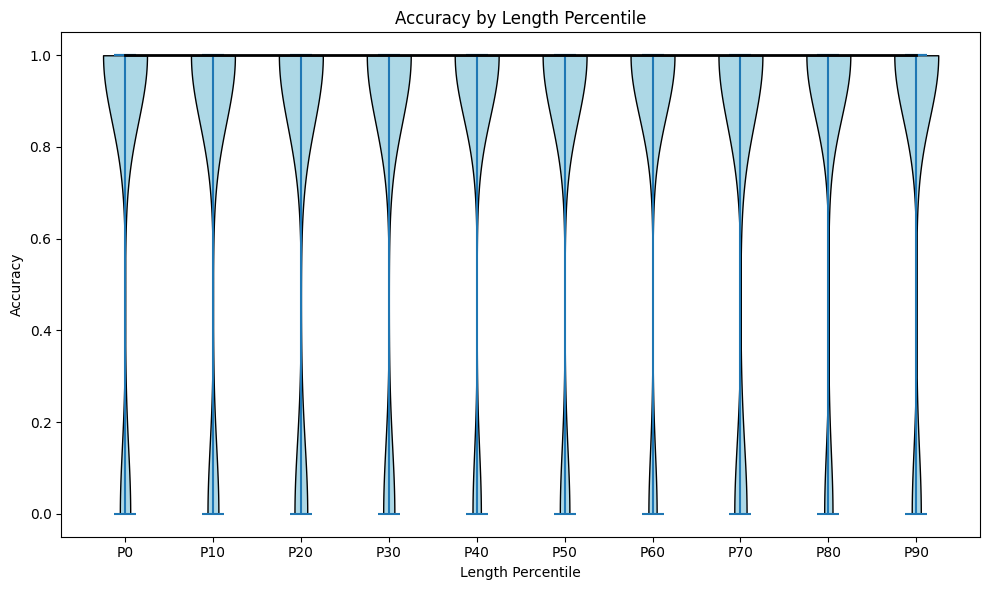

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(data, columns=['length', 'pred', 'truth'])

# Calculate accuracy
df['accuracy'] = (df['pred'] == df['truth']).astype(int)

# Create percentile buckets for length
df['length_percentile'] = pd.qcut(df['length'], q=10, labels=False, duplicates='drop') * 10

# Group by percentile
grouped = df.groupby('length_percentile')['accuracy'].apply(list).reset_index()
grouped.columns = ['length_percentile', 'accuracy']

# Prepare data for violin plot
data_for_plot = [group for group in grouped['accuracy']]

# Create violin plot with matplotlib
plt.figure(figsize=(10, 6))
parts = plt.violinplot(data_for_plot, showmeans=False, showmedians=True)

# Customize the plot
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# Add median lines
plt.plot(range(1, len(data_for_plot) + 1), [np.median(d) for d in data_for_plot], 'k', linewidth=2)

plt.title('Accuracy by Length Percentile')
plt.xlabel('Length Percentile')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(grouped['length_percentile'].unique()) + 1),
           [f'P{i}' for i in sorted(grouped['length_percentile'].unique())])

# Show the plot
plt.tight_layout()
plt.show()

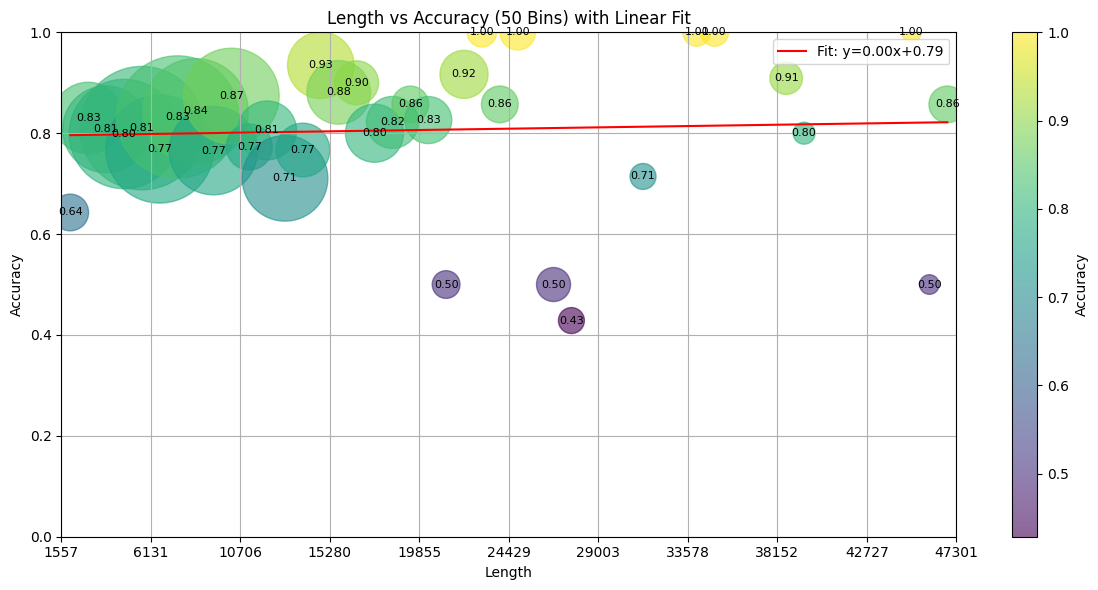

R-squared: 0.00


In [194]:
# Calculate accuracy
df['accuracy'] = (df['pred'] == df['truth']).astype(int)

# Create 50 bins for length
bins = np.linspace(df['length'].min(), df['length'].max(), 51)
df['length_bin'] = pd.cut(df['length'], bins=bins, include_lowest=True, labels=False)

# Group by the bins and calculate the count and mean of accuracies
grouped = df.groupby('length_bin')['accuracy'].agg(['mean', 'count'])

# Calculate actual bin range for x-axis
bin_edges = bins[:-1] + np.diff(bins) / 2  # Use bin centers for x-axis

# Filter out bins with no data to avoid plotting NaNs
valid_data = grouped[grouped['count'] > 0]

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for accuracy means with bubble size by count and color by accuracy
sc = plt.scatter(valid_data.index.map(lambda x: bin_edges[x]), valid_data['mean'],
                 s=valid_data['count'] * 50, c=valid_data['mean'], cmap='viridis', alpha=0.6)

# Fitting a line
from scipy import stats
x = valid_data.index.map(lambda x: bin_edges[x])
y = valid_data['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Generate points for the line of best fit
line = slope * x + intercept

# Plot the line of best fit
plt.plot(x, line, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add a color bar to show accuracy
cbar = plt.colorbar(sc)
cbar.set_label('Accuracy')

# Customize the plot
plt.title('Length vs Accuracy (50 Bins) with Linear Fit')
plt.xlabel('Length')
plt.ylabel('Accuracy')
plt.legend()

# Add text labels for accuracy inside each point (bubble)
for i, row in valid_data.iterrows():
    plt.text(bin_edges[i], row['mean'], f'{row["mean"]:.2f}', ha='center', va='center', color='black', fontsize=8)

# Set x-limits and ticks based on actual bin ranges
plt.xlim(bins[0], bins[-1])
plt.xticks(bins[::5], [f'{b:.0f}' for b in bins[::5]])

# Y-axis limits based on the range of accuracy (0 to 1 for binary accuracy)
plt.ylim(0, 1)

plt.grid(True)
plt.tight_layout()
plt.show()

# Print the correlation coefficient (R-squared)
print(f"R-squared: {r_value**2:.2f}")

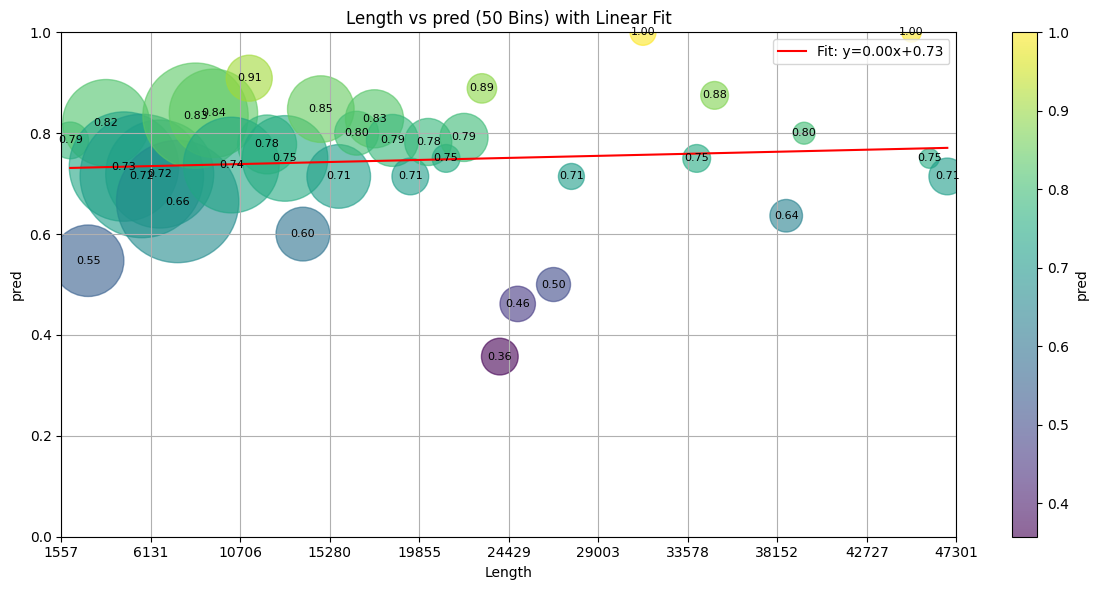

R-squared: 0.01


In [201]:
# Calculate accuracy
# df['accuracy'] = (df['pred'] == df['truth']).astype(int)

agg = 'pred'
# Create 50 bins for length
bins = np.linspace(df['length'].min(), df['length'].max(), 51)
df['length_bin'] = pd.cut(df['length'], bins=bins, include_lowest=True, labels=False)

# Group by the bins and calculate the count and mean of accuracies
grouped = df.groupby('length_bin')[agg].agg(['mean', 'count'])

# Calculate actual bin range for x-axis
bin_edges = bins[:-1] + np.diff(bins) / 2  # Use bin centers for x-axis

# Filter out bins with no data to avoid plotting NaNs
valid_data = grouped[grouped['count'] > 0]

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot for accuracy means with bubble size by count and color by accuracy
sc = plt.scatter(valid_data.index.map(lambda x: bin_edges[x]), valid_data['mean'],
                 s=valid_data['count'] * 50, c=valid_data['mean'], cmap='viridis', alpha=0.6)

# Fitting a line
from scipy import stats
x = valid_data.index.map(lambda x: bin_edges[x])
y = valid_data['mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Generate points for the line of best fit
line = slope * x + intercept

# Plot the line of best fit
plt.plot(x, line, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Add a color bar to show accuracy
cbar = plt.colorbar(sc)
cbar.set_label(agg)

# Customize the plot
plt.title(f'Length vs {agg} (50 Bins) with Linear Fit')
plt.xlabel('Length')
plt.ylabel(agg)
plt.legend()

# Add text labels for accuracy inside each point (bubble)
for i, row in valid_data.iterrows():
    plt.text(bin_edges[i], row['mean'], f'{row["mean"]:.2f}', ha='center', va='center', color='black', fontsize=8)

# Set x-limits and ticks based on actual bin ranges
plt.xlim(bins[0], bins[-1])
plt.xticks(bins[::5], [f'{b:.0f}' for b in bins[::5]])

plt.ylim(0, 1)

plt.grid(True)
plt.tight_layout()
plt.show()

# Print the correlation coefficient (R-squared)
print(f"R-squared: {r_value**2:.2f}")